In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm
import plotly.express as px
#pd.options.plotting.backend = "plotly"
import os
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
from ts_decomposition_function import ts_analysis
import matplotlib.pyplot as plt 
%matplotlib inline

In [5]:
# load in data
cwd      = pd.read_csv('data/Corn_weather_daily.csv', parse_dates = ['time'])
cpa      = pd.read_csv('data/CornPrices_annual.csv')
cities   = pd.read_csv('data/crop_cities.csv')
flux     = pd.read_csv('data/Flux_data_extended.csv')
rflux    = pd.read_csv('data/radioFlux.csv', parse_dates = ['Date'])
scy      = pd.read_csv('data/solar_cycle.csv', parse_dates = ['time-tag'])
scy1     = pd.read_csv('data/solar_cycle_1.csv')
scylist  = pd.read_csv('data/Solar_cycle_list.csv')
sweather = pd.read_csv('data/space_weather.csv')
sun      = pd.read_csv('data/sunSpot.csv')
wwd      = pd.read_csv('data/wheat_weather_daily.csv', parse_dates = ['time'])
wpa      = pd.read_csv('data/WheatPrices_annual.csv')

# convert to a datetime column
flux['time'] = pd.to_datetime(flux['time (yyyy MM dd)'].str.split().str.join('-'))
flux[['time','absolute_f30']].to_csv('data/Flux_data_extended.csv')

<AxesSubplot:xlabel='time'>

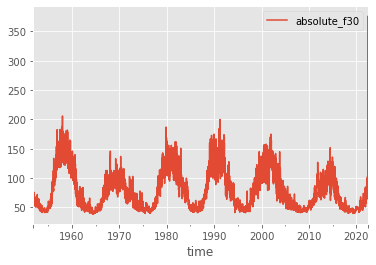

In [3]:
plt.style.use('ggplot')
flux[['time','absolute_f30']].set_index('time').plot()

General approach:

 - data to include:  
     - flux
     - sunspot: mean, percent change / moving percent change
     - precipitation / snow / wspd / etc
     
 - predict:
     - current value
     - future value the next year
     - w/ time series decomposition, w/o
     
  - process:
      - begin w/ OLS -- look at general explainability
      - re-run with GradientBoosting:  do a randomized search w/ 10 fold time series cross validation
      
  - run each with a function

### Quarterly Data Prep

The following section will calculate different metrics at the quarterly level, with the idea that this info is helpful in case there is a growing season for the crops that's sensitive to data in certain quarters of the year.

In [8]:
# quarterly results for different metrics
cwd_q   = cwd.resample('Q', on = 'time').agg(['mean', 'std'])
wwd_q   = wwd.resample('Q', on = 'time').agg(['mean', 'std'])
flux_q  = flux.resample('Q', on = 'time').agg(['mean', 'std'])
sun_q   = scy.resample('Q', on = 'time-tag')['ssn'].mean()

# dataframe of results for corn
q_results = {
    'Year'   : [],
    'Temp-q1': [],
    'Temp-q2': [],
    'Temp-q3': [],
    'Temp-q4': [],
    'Prcp-q1': [],
    'Prcp-q2': [],
    'Prcp-q3': [],
    'Prcp-q4': [],
    'Wspd-q1': [],
    'Wspd-q2': [],
    'Wspd-q3': [],
    'Wspd-q4': [],
    'Wspd-std-q1': [],
    'Wspd-std-q2': [],
    'Wspd-std-q3': [],
    'Wspd-std-q4': [],
    'Flux-q1': [],
    'Flux-q2': [],
    'Flux-q3': [],
    'Flux-q4': [],
    'Sun-q1':  [],
    'Sun-q2':  [],
    'Sun-q3':  [],
    'Sun-q4':  []
}

# and for wheat
wq_results = {
    'Year'   : [],
    'Temp-q1': [],
    'Temp-q2': [],
    'Temp-q3': [],
    'Temp-q4': [],
    'Prcp-q1': [],
    'Prcp-q2': [],
    'Prcp-q3': [],
    'Prcp-q4': [],
    'Wspd-q1': [],
    'Wspd-q2': [],
    'Wspd-q3': [],
    'Wspd-q4': [],
    'Wspd-std-q1': [],
    'Wspd-std-q2': [],
    'Wspd-std-q3': [],
    'Wspd-std-q4': [],
    'Flux-q1': [],
    'Flux-q2': [],
    'Flux-q3': [],
    'Flux-q4': [],
    'Sun-q1':  [],
    'Sun-q2':  [],
    'Sun-q3':  [],
    'Sun-q4':  []    
}

cur_year = 1979

# fill in values for the weather data
for idx in cwd_q.index:

    if idx.year != cur_year:
        q_results['Year'].append(idx.year)
        wq_results['Year'].append(idx.year)
        cur_year = idx.year
    if idx.quarter == 1:
        q_results['Temp-q1'].append(cwd_q.loc[idx]['tavg']['mean'])
        q_results['Prcp-q1'].append(cwd_q.loc[idx]['prcp']['mean'])
        q_results['Wspd-q1'].append(cwd_q.loc[idx]['wspd']['mean'])
        q_results['Wspd-std-q1'].append(cwd_q.loc[idx]['wspd']['std'])
        q_results['Flux-q1'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        q_results['Sun-q1'].append(sun_q.loc[idx])
        
        wq_results['Temp-q1'].append(wwd_q.loc[idx]['tavg']['mean'])
        wq_results['Prcp-q1'].append(wwd_q.loc[idx]['prcp']['mean'])
        wq_results['Wspd-q1'].append(wwd_q.loc[idx]['wspd']['mean'])
        wq_results['Wspd-std-q1'].append(wwd_q.loc[idx]['wspd']['std'])
        wq_results['Flux-q1'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        wq_results['Sun-q1'].append(sun_q.loc[idx])
        
    elif idx.quarter == 2:
        q_results['Temp-q2'].append(cwd_q.loc[idx]['tavg']['mean'])
        q_results['Prcp-q2'].append(cwd_q.loc[idx]['prcp']['mean'])  
        q_results['Wspd-q2'].append(cwd_q.loc[idx]['wspd']['mean'])
        q_results['Wspd-std-q2'].append(cwd_q.loc[idx]['wspd']['std'])
        q_results['Flux-q2'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        q_results['Sun-q2'].append(sun_q.loc[idx])
        
        wq_results['Temp-q2'].append(wwd_q.loc[idx]['tavg']['mean'])
        wq_results['Prcp-q2'].append(wwd_q.loc[idx]['prcp']['mean'])
        wq_results['Wspd-q2'].append(wwd_q.loc[idx]['wspd']['mean'])
        wq_results['Wspd-std-q2'].append(wwd_q.loc[idx]['wspd']['std'])
        wq_results['Flux-q2'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        wq_results['Sun-q2'].append(sun_q.loc[idx])

    elif idx.quarter == 3:
        q_results['Temp-q3'].append(cwd_q.loc[idx]['tavg']['mean'])
        q_results['Prcp-q3'].append(cwd_q.loc[idx]['prcp']['mean']) 
        q_results['Wspd-q3'].append(cwd_q.loc[idx]['wspd']['mean'])
        q_results['Wspd-std-q3'].append(cwd_q.loc[idx]['wspd']['std'])
        q_results['Flux-q3'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        
        wq_results['Temp-q3'].append(wwd_q.loc[idx]['tavg']['mean'])
        wq_results['Prcp-q3'].append(wwd_q.loc[idx]['prcp']['mean'])
        wq_results['Wspd-q3'].append(wwd_q.loc[idx]['wspd']['mean'])
        wq_results['Wspd-std-q3'].append(wwd_q.loc[idx]['wspd']['std'])
        wq_results['Flux-q3'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        try:
            q_results['Sun-q3'].append(sun_q.loc[idx])
            wq_results['Sun-q3'].append(sun_q.loc[idx])
        except:
            continue

    elif idx.quarter == 4:
        q_results['Temp-q4'].append(cwd_q.loc[idx]['tavg']['mean'])
        q_results['Prcp-q4'].append(cwd_q.loc[idx]['prcp']['mean']) 
        q_results['Wspd-q4'].append(cwd_q.loc[idx]['wspd']['mean'])
        q_results['Wspd-std-q4'].append(cwd_q.loc[idx]['wspd']['std'])
        q_results['Flux-q4'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        q_results['Sun-q4'].append(sun_q.loc[idx])
        
        wq_results['Temp-q4'].append(wwd_q.loc[idx]['tavg']['mean'])
        wq_results['Prcp-q4'].append(wwd_q.loc[idx]['prcp']['mean'])
        wq_results['Wspd-q4'].append(wwd_q.loc[idx]['wspd']['mean'])
        wq_results['Wspd-std-q4'].append(wwd_q.loc[idx]['wspd']['std'])
        wq_results['Flux-q4'].append(flux_q.loc[idx]['absolute_f30']['mean'])
        wq_results['Sun-q4'].append(sun_q.loc[idx])
        
# backfill the previously missing values
q_results['Temp-q4'].append(q_results['Temp-q4'][-1])
q_results['Prcp-q4'].append(q_results['Prcp-q4'][-1])
q_results['Wspd-q4'].append(q_results['Wspd-q4'][-1])
q_results['Wspd-std-q4'].append(q_results['Wspd-std-q4'][-1])
q_results['Flux-q4'].append(q_results['Flux-q4'][-1])
q_results['Sun-q4'].append(q_results['Sun-q4'][-1])
q_results['Sun-q3'].append(q_results['Sun-q3'][-1])

wq_results['Temp-q4'].append(q_results['Temp-q4'][-1])
wq_results['Prcp-q4'].append(q_results['Prcp-q4'][-1])
wq_results['Wspd-q4'].append(q_results['Wspd-q4'][-1])
wq_results['Wspd-std-q4'].append(q_results['Wspd-std-q4'][-1])
wq_results['Flux-q4'].append(q_results['Flux-q4'][-1])
wq_results['Sun-q4'].append(q_results['Sun-q4'][-1])
wq_results['Sun-q3'].append(q_results['Sun-q3'][-1])
     
q_results = pd.DataFrame(q_results)
wq_results = pd.DataFrame(wq_results)

# complete final dataset
q_results = q_results.merge(cpa, on = 'Year', how = 'left')
wq_results = wq_results.merge(cpa, on = 'Year', how = 'left')

In [34]:
wq_results

,Year,Temp-q1,Temp-q2,Temp-q3,Temp-q4,Prcp-q1,Prcp-q2,Prcp-q3,Prcp-q4,Wspd-q1,...,Sun-q1,Sun-q2,Sun-q3,Sun-q4,AvgClose,Open,High,Low,Close,PercentChange
0,1980,-4.478755,15.911296,21.084783,3.116123,1.171062,1.599634,2.425000,1.764130,17.083700,...,208.066667,236.533333,201.400000,229.900000,3.15,2.87,4.06,2.58,3.78,0.3068
1,1981,-1.297778,15.050741,20.183696,3.135507,1.128148,2.895604,3.302899,2.155797,14.588519,...,181.033333,183.866667,231.033333,199.200000,3.29,3.82,3.82,2.63,2.71,-0.2844
2,1982,-6.383704,13.297407,20.065580,3.640580,1.724444,3.421612,2.324638,1.818841,15.446296,...,200.600000,151.100000,156.233333,143.600000,2.55,2.72,2.84,2.14,2.45,-0.0952
3,1983,-0.710741,12.862593,21.790217,0.977536,1.842593,3.266667,1.133696,2.500362,15.796296,...,92.433333,124.533333,91.600000,54.600000,3.18,2.44,3.69,2.43,3.37,0.3779
4,1984,-2.731868,13.851111,20.167210,3.240217,1.755311,3.426740,1.584420,2.114130,14.027473,...,100.566667,84.133333,37.766667,20.166667,3.14,3.30,3.62,2.65,2.69,-0.2016
5,1985,-3.786481,14.592593,19.473913,0.510145,1.187037,2.433700,3.461957,2.315580,15.615185,...,18.466667,27.033333,18.100000,18.566667,2.54,2.71,2.86,2.15,2.48,-0.0780
6,1986,-1.076296,15.181852,19.459058,2.713406,1.324444,2.632601,3.955435,1.721014,15.845556,...,14.833333,13.033333,11.033333,20.433333,2.01,2.48,2.49,1.55,1.60,-0.3555
7,1987,-0.968889,16.483704,20.139493,3.591304,1.461481,2.694139,2.739493,1.261957,15.670000,...,10.200000,34.633333,42.766667,47.100000,1.73,1.57,2.02,1.43,1.85,0.1547
8,1988,-3.473993,16.412037,21.268116,2.821377,1.033333,1.532234,2.622826,1.078261,16.241392,...,69.033333,102.433333,137.833333,181.500000,2.55,1.88,3.54,1.88,2.85,0.5399
9,1989,-3.272222,14.606296,20.461594,0.846739,0.922222,2.491941,3.406159,1.260145,15.948148,...,196.400000,215.400000,212.533333,220.600000,2.54,2.81,2.90,2.17,2.40,-0.1573


### Annual Data Prep

We'll also look at data for annual values to compare the two.

In [9]:
# first with basic raw values:  both wheat and corn
cwd_annual      = cwd.resample('Y',  on = 'time').agg(['max', 'min', 'mean', 'std'])
wwd_annual      = wwd.resample('Y',  on = 'time').agg(['mean', 'std'])
flux_annual     = flux.resample('Y', on = 'time').agg(['max', 'min', 'mean', 'std'])
sun_annual      = scy.resample('Y',  on = 'time-tag')[['ssn']].mean()

# fill in data for corn
acd             = pd.DataFrame()
acd['avg_temp'] = cwd_annual['tavg']['mean']
acd['std_temp'] = cwd_annual['tavg']['std']
acd['avg_prcp'] = cwd_annual['prcp']['mean']
acd['std_prcp'] = cwd_annual['prcp']['std']
acd['avg_snow'] = cwd_annual['snow']['mean']
acd['avg_tsun'] = cwd_annual['tsun']['mean']
acd['avg_pres'] = cwd_annual['tsun']['mean']
acd['avg_wspd'] = cwd_annual['wspd']['mean']
acd['avg_wdir'] = cwd_annual['wdir']['mean']
acd['avg_flux'] = flux_annual['absolute_f30']['mean']
acd['avg_sun']  = sun_annual['ssn']
acd['Year']     = cwd_annual.index.year

# treat missing values -- assuming missing values means it didn't happen
acd['avg_tsun'] = acd['avg_tsun'].fillna(0)
acd['avg_pres'] = acd['avg_pres'].fillna(0)

# fill in data for wheat
awd             = pd.DataFrame()
awd['avg_temp'] = wwd_annual['tavg']['mean']
awd['std_temp'] = wwd_annual['tavg']['std']
awd['avg_prcp'] = wwd_annual['prcp']['mean']
awd['std_prcp'] = wwd_annual['prcp']['std']
awd['avg_snow'] = wwd_annual['snow']['mean']
awd['avg_tsun'] = wwd_annual['tsun']['mean']
awd['avg_pres'] = wwd_annual['tsun']['mean']
awd['avg_wspd'] = wwd_annual['wspd']['mean']
awd['avg_wdir'] = wwd_annual['wdir']['mean']
awd['avg_flux'] = flux_annual['absolute_f30']['mean']
awd['avg_sun']  = sun_annual['ssn']
awd['Year']     = wwd_annual.index.year

# treat missing values -- assuming missing values means it didn't happen
awd['avg_tsun'] = awd['avg_tsun'].fillna(0)
awd['avg_pres'] = awd['avg_pres'].fillna(0)

# create the final dataset
acd = acd.merge(cpa, on = 'Year', how = 'left')
awd = awd.merge(cpa, on = 'Year', how = 'left')

### Regressions to Determine Relevance - Corn

Here we'll run through regression analysis with different combinations of variables and over different time horizons with different types of data to see which ones are relevant.

In [10]:
# OLS with yearly data - only windspeed is close to being relevant -- sun and flux don't seem to matter
X = acd.iloc[:, :12]
y = acd['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.538
Model:                            OLS   Adj. R-squared:                  0.375
Method:                 Least Squares   F-statistic:                     3.288
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00441
Time:                        20:33:26   Log-Likelihood:                -57.659
No. Observations:                  43   AIC:                             139.3
Df Residuals:                      31   BIC:                             160.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -162.4867     78.464     -2.071      0.0

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [11]:
# refit with just year -- almost the exact same results with all of the other variables included
X = acd[['Year']]
y = acd['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.374
Model:                            OLS   Adj. R-squared:                  0.359
Method:                 Least Squares   F-statistic:                     24.48
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           1.33e-05
Time:                        20:33:26   Log-Likelihood:                -64.218
No. Observations:                  43   AIC:                             132.4
Df Residuals:                      41   BIC:                             136.0
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       -130.8615     27.131     -4.823      0.0

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [12]:
# code for quarterly data -- predicting the average close most are relevant, time does not matter
# almost every weather metric is relevant in either the second or third quarter
X = q_results.loc[:, ['Year', 'Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']]
y = q_results['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.678
Method:                 Least Squares   F-statistic:                     9.033
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           6.17e-07
Time:                        20:33:26   Log-Likelihood:                -43.401
No. Observations:                  43   AIC:                             110.8
Df Residuals:                      31   BIC:                             131.9
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          89.4617     64.394      1.389      

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [13]:
# will take same data, but try and predict t + 1 years into the future: flux, sun & windspeed in q3 are all important
X = q_results.loc[1:, ['Year', 'Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']]
y = q_results['AvgClose'].shift()[1:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.700
Model:                            OLS   Adj. R-squared:                  0.590
Method:                 Least Squares   F-statistic:                     6.369
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           2.56e-05
Time:                        20:33:27   Log-Likelihood:                -43.279
No. Observations:                  42   AIC:                             110.6
Df Residuals:                      30   BIC:                             131.4
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const         128.0956     73.205      1.750      

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [14]:
# if you redo results with just time, precipitation, windspeed, sun and flux in q3
X = q_results.loc[:, ['Year', 'Wspd-q2', 'Wspd-q3', 'Prcp-q3', 'Sun-q3', 'Flux-q3']]
y = q_results['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.649
Model:                            OLS   Adj. R-squared:                  0.591
Method:                 Least Squares   F-statistic:                     11.11
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           5.45e-07
Time:                        20:33:27   Log-Likelihood:                -51.752
No. Observations:                  43   AIC:                             117.5
Df Residuals:                      36   BIC:                             129.8
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          7.3295     55.019      0.133      0.8

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [15]:
# if you redo results with just time, precipitation, windspeed, sun and flux in q3
X = q_results.loc[1:, ['Year', 'Wspd-q2', 'Wspd-q3', 'Prcp-q3', 'Sun-q3', 'Flux-q3']]
y = q_results['AvgClose'].shift()[1:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.633
Model:                            OLS   Adj. R-squared:                  0.570
Method:                 Least Squares   F-statistic:                     10.07
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           1.84e-06
Time:                        20:33:27   Log-Likelihood:                -47.517
No. Observations:                  42   AIC:                             109.0
Df Residuals:                      35   BIC:                             121.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         35.3524     54.409      0.650      0.5

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [16]:
# no longer valid two years into the future
X = q_results.loc[2:, ['Year', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 'Flux-q3', 'Sun-q3']]
y = q_results['AvgClose'].shift(2)[2:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.404
Model:                            OLS   Adj. R-squared:                  0.299
Method:                 Least Squares   F-statistic:                     3.847
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00492
Time:                        20:33:27   Log-Likelihood:                -54.707
No. Observations:                  41   AIC:                             123.4
Df Residuals:                      34   BIC:                             135.4
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -43.2252     67.623     -0.639      0.5

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Regression Analysis -- Wheat

In [17]:
# OLS with yearly data - very noisy, only wind direction and std precipitation seem to matter
X = awd.iloc[:, :12]
y = awd['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.480
Method:                 Least Squares   F-statistic:                     4.525
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           0.000432
Time:                        20:33:27   Log-Likelihood:                -53.691
No. Observations:                  43   AIC:                             131.4
Df Residuals:                      31   BIC:                             152.5
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -93.0956     60.828     -1.530      0.1

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [18]:
# with just the two most relevant columns and time -- only wind direction matters
X = awd.loc[:, ['avg_wspd', 'avg_wdir', 'Year', 'std_prcp']]
y = awd['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.520
Model:                            OLS   Adj. R-squared:                  0.469
Method:                 Least Squares   F-statistic:                     10.29
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           9.60e-06
Time:                        20:33:27   Log-Likelihood:                -58.508
No. Observations:                  43   AIC:                             127.0
Df Residuals:                      38   BIC:                             135.8
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -73.0501     44.020     -1.659      0.1

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [19]:
# will now look at quarterly data -- including all variables -- q3 seems to be most important
X = wq_results.iloc[:, :25]
y = wq_results['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.836
Model:                            OLS   Adj. R-squared:                  0.594
Method:                 Least Squares   F-statistic:                     3.462
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00524
Time:                        20:33:27   Log-Likelihood:                -35.438
No. Observations:                  43   AIC:                             122.9
Df Residuals:                      17   BIC:                             168.7
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          60.4438     78.970      0.765      

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [20]:
# redo, with just q3 data
X = wq_results.loc[:, ['Wspd-std-q3', 'Flux-q3', 'Sun-q3', 'Wspd-q3', 'Prcp-q3', 'Temp-q3', 'Year']]
y = wq_results['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.585
Model:                            OLS   Adj. R-squared:                  0.501
Method:                 Least Squares   F-statistic:                     7.036
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           2.96e-05
Time:                        20:33:27   Log-Likelihood:                -55.396
No. Observations:                  43   AIC:                             126.8
Df Residuals:                      35   BIC:                             140.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          21.5136     52.357      0.411      

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [21]:
# work down to the parsimonious model with just relevant characteristics
X = wq_results.loc[:, ['Flux-q3', 'Sun-q3', 'Wspd-q3', 'Temp-q3', 'Year']]
y = wq_results['AvgClose']
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.557
Model:                            OLS   Adj. R-squared:                  0.497
Method:                 Least Squares   F-statistic:                     9.288
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           8.52e-06
Time:                        20:33:27   Log-Likelihood:                -56.799
No. Observations:                  43   AIC:                             125.6
Df Residuals:                      37   BIC:                             136.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         20.7003     50.763      0.408      0.6

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [22]:
# predict one year into the future -- rsquare value went up!
X = wq_results.loc[1:, ['Flux-q3', 'Sun-q3', 'Wspd-q3', 'Temp-q3', 'Year']]
y = wq_results['AvgClose'].shift()[1:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.644
Model:                            OLS   Adj. R-squared:                  0.595
Method:                 Least Squares   F-statistic:                     13.03
Date:                Wed, 20 Jul 2022   Prob (F-statistic):           2.88e-07
Time:                        20:33:27   Log-Likelihood:                -46.880
No. Observations:                  42   AIC:                             105.8
Df Residuals:                      36   BIC:                             116.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         14.7060     41.862      0.351      0.7

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [23]:
# two years into the future -- sun & flux are still relevant
X = wq_results.loc[2:, ['Flux-q3', 'Sun-q3', 'Wspd-q3', 'Temp-q3', 'Year']]
y = wq_results['AvgClose'].shift(2)[2:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.346
Method:                 Least Squares   F-statistic:                     5.238
Date:                Wed, 20 Jul 2022   Prob (F-statistic):            0.00108
Time:                        20:33:27   Log-Likelihood:                -53.878
No. Observations:                  41   AIC:                             119.8
Df Residuals:                      35   BIC:                             130.0
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -42.9179     52.614     -0.816      0.4

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


In [24]:
# three years into the future -- nothing is relevant
X = wq_results.loc[3:, ['Flux-q3', 'Sun-q3', 'Wspd-q3', 'Temp-q3', 'Year']]
y = wq_results['AvgClose'].shift(3)[3:]
X = sm.add_constant(X)

mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:               AvgClose   R-squared:                       0.324
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     3.257
Date:                Wed, 20 Jul 2022   Prob (F-statistic):             0.0165
Time:                        20:33:27   Log-Likelihood:                -56.338
No. Observations:                  40   AIC:                             124.7
Df Residuals:                      34   BIC:                             134.8
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -94.1098     58.569     -1.607      0.1

/Users/jerald/miniforge3/envs/dsenv/lib/python3.9/site-packages/statsmodels/tsa/tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


### Gradient Boosting

We'll now build off of some of the results from previous sections, to see if we can use quarterly data with tree based models to try and estimate wheat and corn prices, using some of the findings from the previous section.  Mainly, that data from the third quarter seems to be most relevant for estimating weather impacts on the price.

We'll use gradient boosting, since it's generally been established as the most powerful predictive model for tabular data among the tree based family of statistical models.  We'll use this to compare with our results from linear regression, and see if we can perhaps improve on our previous results.  

Since using quarterly data gave us the best results, we'll start by only considering data from that using only the second and third quarters.

To ensure our results are thorough, we'll use 10-fold cross validation with the mean squared error as a metric to test our results, and look at the final score and feature importances for each model that was run before.

In [25]:
def build_and_fit_model(mod, X, y, params):
    print("Getting ready to do a parameter search for best parameters")
    grid = GridSearchCV(mod, params, cv = 10, scoring = 'neg_mean_squared_error')
    grid.fit(X, y)
    print("Finished.")
    mod.set_params(**grid.best_params_)
    mod.fit(X, y)
    score = mod.score(X, y)
    importances = pd.DataFrame({
    'Col': X.columns,
    'Imp': mod.feature_importances_
    }).sort_values(by = 'Imp', ascending = False)
    return score, grid.best_params_, importances

In [27]:
# function for corn data with quarterly metrics
mod = GradientBoostingRegressor()
params = {
    'n_estimators':  [10, 20, 50, 100],
    'learning_rate': [.01, .05, .1, .2],
    'max_depth': [2, 3, 4],
    'max_features': [.4, .5, .6, .7]
}


# quarterly data for corn
X = q_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']]
y = q_results['AvgClose']

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
# model score
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.8527240403150763, boosting rounds: 10, learning rate: 0.1 tree depth: 4


In [ ]:
# and model importances -- windspeed and precipiation dominate
feats

,Col,Imp
5,Wspd-std-q3,0.307479
3,Wspd-q3,0.197344
1,Prcp-q3,0.136968
4,Wspd-std-q2,0.089273
7,Flux-q3,0.078590
8,Sun-q2,0.059877
9,Sun-q3,0.056641
2,Wspd-q2,0.036328
0,Prcp-q2,0.032985
6,Flux-q2,0.004514


We'll do similar results for wheat to see how they work.

In [ ]:
# quarterly data for corn
X = wq_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']]
y = wq_results['AvgClose']

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.9401005878934143, boosting rounds: 20, learning rate: 0.2 tree depth: 2


In [ ]:
# and model importances -- windspeed is most relevant
feats

,Col,Imp
3,Wspd-q3,0.303785
5,Wspd-std-q3,0.226199
2,Wspd-q2,0.222621
9,Sun-q3,0.089722
8,Sun-q2,0.076464
4,Wspd-std-q2,0.047157
0,Prcp-q2,0.016500
7,Flux-q3,0.008708
6,Flux-q2,0.005568
1,Prcp-q3,0.003276


We'll now try and use these values for predictive measures, by trying to measure 1, 2, and 3 years out into the future.

We'll do it for both corn and wheat.

In [ ]:
# 1 year into the future
# quarterly data for corn
X = q_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']][1:]
y = q_results['AvgClose'].shift()[1:]

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.9614495330005616, boosting rounds: 10, learning rate: 0.2 tree depth: 3


In [ ]:
# persistent results
feats

,Col,Imp
3,Wspd-q3,0.571796
8,Sun-q2,0.265935
6,Flux-q2,0.047805
4,Wspd-std-q2,0.029505
5,Wspd-std-q3,0.020975
7,Flux-q3,0.016532
0,Prcp-q2,0.016061
2,Wspd-q2,0.014408
1,Prcp-q3,0.008909
9,Sun-q3,0.008074


In [ ]:
# two years into the future
X = q_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']][2:]
y = q_results['AvgClose'].shift(2)[2:]

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.8875197407980118, boosting rounds: 20, learning rate: 0.1 tree depth: 2


In [ ]:
# importances
feats

,Col,Imp
3,Wspd-q3,0.346790
4,Wspd-std-q2,0.239238
8,Sun-q2,0.125607
0,Prcp-q2,0.121528
6,Flux-q2,0.075088
7,Flux-q3,0.043695
5,Wspd-std-q3,0.033203
2,Wspd-q2,0.010946
1,Prcp-q3,0.003908
9,Sun-q3,0.000000


We'll now repeat for wheat.

In [ ]:
# 1 year into the future
# quarterly data for wheat
X = wq_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']][1:]
y = wq_results['AvgClose'].shift()[1:]

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.9741996380413235, boosting rounds: 20, learning rate: 0.1 tree depth: 4


In [ ]:
# importances
feats

,Col,Imp
3,Wspd-q3,0.396855
8,Sun-q2,0.231196
2,Wspd-q2,0.162369
7,Flux-q3,0.065021
5,Wspd-std-q3,0.060167
4,Wspd-std-q2,0.039649
6,Flux-q2,0.016636
9,Sun-q3,0.012876
1,Prcp-q3,0.007782
0,Prcp-q2,0.007448


In [ ]:
# two years into the future
X = wq_results.loc[:, ['Prcp-q2', 'Prcp-q3', 'Wspd-q2', 'Wspd-q3', 
                      'Wspd-std-q2', 'Wspd-std-q3', 'Flux-q2', 'Flux-q3', 'Sun-q2', 'Sun-q3']][2:]
y = wq_results['AvgClose'].shift(2)[2:]

score, b_params, feats = build_and_fit_model(mod, X, y, params)

Getting ready to do a parameter search for best parameters
Finished.


In [ ]:
print(f"""model score: {score}, boosting rounds: {b_params['n_estimators']}, learning rate: {b_params['learning_rate']} tree depth: {b_params['max_depth']}""")

model score: 0.9898778127396707, boosting rounds: 50, learning rate: 0.2 tree depth: 2


In [ ]:
feats

,Col,Imp
2,Wspd-q2,0.283141
3,Wspd-q3,0.221184
8,Sun-q2,0.160673
6,Flux-q2,0.130167
7,Flux-q3,0.088979
5,Wspd-std-q3,0.034517
9,Sun-q3,0.028417
4,Wspd-std-q2,0.026019
0,Prcp-q2,0.016176
1,Prcp-q3,0.010727


0     3.15
1     3.29
2     2.55
3     3.18
4     3.14
5     2.54
6     2.01
7     1.73
8     2.55
9     2.54
10    2.52
11    2.47
12    2.39
13    2.39
14    2.50
15    2.81
16    3.67
17    2.75
18    2.38
19    2.12
20    2.12
21    2.11
22    2.29
23    2.33
24    2.54
25    2.11
26    2.63
27    3.76
28    5.30
29    3.75
30    4.31
31    6.80
32    6.92
33    5.69
34    4.16
35    3.78
36    3.60
37    3.62
38    3.70
39    3.85
40    3.64
41    5.75
42    7.23
Name: AvgClose, dtype: float64

We similar traits across all models.  Wind speed in the second and third quarter is the most important predictive trait in all circumstances.  When predicting into the future, sunspot and flux activity increases in importance.